<a href="https://colab.research.google.com/github/BrendaGilisho/Clustering-techniques-in-data-mining/blob/main/Clustering_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 27.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=b41e277fb677976f39ece81fa1377566b41927674774b2901be001566d23eb0a
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# Importing necessary packages
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.context import SparkContext 
from google.colab import files


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##upload dataset
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

In [ ]:
data = spark.read.csv('/content/drive/My Drive/Colab Notebooks/Datamining/books - description (1) (1).csv', header=True, encoding='latin1')


In [ ]:
data.show(4)

+--------------------+--------------------+--------------------+
|             book_id|                name|         description|
+--------------------+--------------------+--------------------+
|                4833|    The Glass Castle|A tender, moving ...|
|Jeannette Walls g...| they lived like ...| moving among Sou...|
|               Later| when the money r...| or the romance o...|
|What is so astoni...| but that she des...|   but also a tender|
+--------------------+--------------------+--------------------+
only showing top 4 rows



In [ ]:
data.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)



**Data Preprocessing**

In [ ]:
##cast id column to appropriate datatype
from pyspark.sql.functions import col

data_set = data.filter(col("book_id").cast("int").isNotNull())

In [ ]:
from pyspark.sql.types import IntegerType
data_set = data_set.withColumn("book_id", data_set["book_id"].cast(IntegerType()))

In [ ]:
data_set.show(20)

+-------+--------------------+--------------------+
|book_id|                name|         description|
+-------+--------------------+--------------------+
|   4833|    The Glass Castle|A tender, moving ...|
|    590|Night (The Night ...|Born into a Jewis...|
|   4264|Angela's Ashes (F...|Imbued on every p...|
|   3361|    Eat, Pray, Love |A celebrated writ...|
|   4535|Into Thin Air: A ...|"A bank of clouds...|
|    518|Tuesdays with Morrie|Maybe it was a gr...|
|   3781|Running with Scis...|The true story of...|
|   3190|       Into the Wild|In April 1992 a y...|
|   3147|I Know Why the Ca...|"Sent by their mo...|
|    225|"A Child Called "...|               #1) "|
|   3035|Chickens, Mules a...|Perhaps if Joe an...|
|     99|Persepolis: The S...|Wise, funny, and ...|
|   3594|The Autobiography...|"Through a life o...|
|   4971|The Hiding Place:...|At one time Corri...|
|   1381|All Creatures Gre...|Delve into the ma...|
|   3099|         Confessions|Augustine's Confe...|
|     45|Me 

In [ ]:
data_set.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)



In [ ]:
###handling missing values
# Calculate the number of rows in the DataFrame
num_rows = data_set.count()
num_rows

136

In [ ]:
#show number of missing values in each column
# Sum the number of missing values in each column
missing_values = [data_set.filter(data_set[col].isNull()).count() for col in data_set.columns]

# Print the sum of missing values for each column
for col, missing in zip(data_set.columns, missing_values):
    print(f"{col}: {missing}")

book_id: 0
name: 0
description: 0


In [ ]:
# Tokenize sentences
from pyspark.ml.feature import CountVectorizer, RegexTokenizer

regexTokenizer = RegexTokenizer(inputCol="description", outputCol="description_tokenized", pattern="\\W")
Data = regexTokenizer.transform(data_set)
Data.show()

+-------+--------------------+--------------------+---------------------+
|book_id|                name|         description|description_tokenized|
+-------+--------------------+--------------------+---------------------+
|   4833|    The Glass Castle|A tender, moving ...| [a, tender, movin...|
|    590|Night (The Night ...|Born into a Jewis...| [born, into, a, j...|
|   4264|Angela's Ashes (F...|Imbued on every p...| [imbued, on, ever...|
|   3361|    Eat, Pray, Love |A celebrated writ...| [a, celebrated, w...|
|   4535|Into Thin Air: A ...|"A bank of clouds...| [a, bank, of, clo...|
|    518|Tuesdays with Morrie|Maybe it was a gr...| [maybe, it, was, ...|
|   3781|Running with Scis...|The true story of...| [the, true, story...|
|   3190|       Into the Wild|In April 1992 a y...| [in, april, 1992,...|
|   3147|I Know Why the Ca...|"Sent by their mo...| [sent, by, their,...|
|    225|"A Child Called "...|               #1) "|                  [1]|
|   3035|Chickens, Mules a...|Perhaps 

In [ ]:
regexTokenizer = RegexTokenizer(inputCol="name", outputCol="name_tokenized", pattern="\\W")
Data = regexTokenizer.transform(Data)
Data.show()

+-------+--------------------+--------------------+---------------------+--------------------+
|book_id|                name|         description|description_tokenized|      name_tokenized|
+-------+--------------------+--------------------+---------------------+--------------------+
|   4833|    The Glass Castle|A tender, moving ...| [a, tender, movin...|[the, glass, castle]|
|    590|Night (The Night ...|Born into a Jewis...| [born, into, a, j...|[night, the, nigh...|
|   4264|Angela's Ashes (F...|Imbued on every p...| [imbued, on, ever...|[angela, s, ashes...|
|   3361|    Eat, Pray, Love |A celebrated writ...| [a, celebrated, w...|   [eat, pray, love]|
|   4535|Into Thin Air: A ...|"A bank of clouds...| [a, bank, of, clo...|[into, thin, air,...|
|    518|Tuesdays with Morrie|Maybe it was a gr...| [maybe, it, was, ...|[tuesdays, with, ...|
|   3781|Running with Scis...|The true story of...| [the, true, story...|[running, with, s...|
|   3190|       Into the Wild|In April 1992 a y...

In [ ]:
# Remove stop words
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF

remover = StopWordsRemover(inputCol="description_tokenized", outputCol="desc_removedwords")
data = remover.transform(Data)
data.show()

+-------+--------------------+--------------------+---------------------+--------------------+--------------------+
|book_id|                name|         description|description_tokenized|      name_tokenized|   desc_removedwords|
+-------+--------------------+--------------------+---------------------+--------------------+--------------------+
|   4833|    The Glass Castle|A tender, moving ...| [a, tender, movin...|[the, glass, castle]|[tender, moving, ...|
|    590|Night (The Night ...|Born into a Jewis...| [born, into, a, j...|[night, the, nigh...|[born, jewish, gh...|
|   4264|Angela's Ashes (F...|Imbued on every p...| [imbued, on, ever...|[angela, s, ashes...|[imbued, every, p...|
|   3361|    Eat, Pray, Love |A celebrated writ...| [a, celebrated, w...|   [eat, pray, love]|[celebrated, writ...|
|   4535|Into Thin Air: A ...|"A bank of clouds...| [a, bank, of, clo...|[into, thin, air,...|[bank, clouds, as...|
|    518|Tuesdays with Morrie|Maybe it was a gr...| [maybe, it, was, ...

In [ ]:
remover = StopWordsRemover(inputCol="name_tokenized", outputCol="name_removedwords")
data = remover.transform(data)
data.show()

+-------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|book_id|                name|         description|description_tokenized|      name_tokenized|   desc_removedwords|   name_removedwords|
+-------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+
|   4833|    The Glass Castle|A tender, moving ...| [a, tender, movin...|[the, glass, castle]|[tender, moving, ...|     [glass, castle]|
|    590|Night (The Night ...|Born into a Jewis...| [born, into, a, j...|[night, the, nigh...|[born, jewish, gh...|[night, night, tr...|
|   4264|Angela's Ashes (F...|Imbued on every p...| [imbued, on, ever...|[angela, s, ashes...|[imbued, every, p...|[angela, ashes, f...|
|   3361|    Eat, Pray, Love |A celebrated writ...| [a, celebrated, w...|   [eat, pray, love]|[celebrated, writ...|   [eat, pray, love]|
|   4535|Into Thin Air: A ...|"A bank of 

In [ ]:
new_df = data.select("desc_removedwords","name_removedwords")
new_df.show()

+--------------------+--------------------+
|   desc_removedwords|   name_removedwords|
+--------------------+--------------------+
|[tender, moving, ...|     [glass, castle]|
|[born, jewish, gh...|[night, night, tr...|
|[imbued, every, p...|[angela, ashes, f...|
|[celebrated, writ...|   [eat, pray, love]|
|[bank, clouds, as...|[thin, air, perso...|
|[maybe, grandpare...|  [tuesdays, morrie]|
|[true, story, out...| [running, scissors]|
|[april, 1992, you...|              [wild]|
|[sent, mother, li...|[know, caged, bir...|
|                 [1]|[child, called, d...|
|[perhaps, joe, vi...|[chickens, mules,...|
|[wise, funny, hea...|[persepolis, stor...|
|[life, passion, s...|[autobiography, m...|
|[one, time, corri...|[hiding, place, t...|
|[delve, magical, ...|[creatures, great...|
|[augustine, confe...|       [confessions]|
|[david, sedaris, ...|[talk, pretty, on...|
|[john, jenny, beg...|[marley, life, lo...|
|[enthralling, oft...|       [john, adams]|
|[psychiatrist, vi...|[man, sear

In [ ]:
# Convert the description column into a numerical representation using CountVectorizer
cv = CountVectorizer(inputCol="desc_removedwords", outputCol="features")
cvModel = cv.fit(new_df)
numericData = cvModel.transform(new_df)

cv = CountVectorizer(inputCol="name_removedwords", outputCol="name_features")
cvModel = cv.fit(new_df)
numericData = cvModel.transform(new_df)

numericData.show()

+--------------------+--------------------+--------------------+
|   desc_removedwords|   name_removedwords|            features|
+--------------------+--------------------+--------------------+
|[tender, moving, ...|     [glass, castle]|(3182,[1,13,14,17...|
|[born, jewish, gh...|[night, night, tr...|(3182,[2,6,14,28,...|
|[imbued, every, p...|[angela, ashes, f...|(3182,[0,41,217,7...|
|[celebrated, writ...|   [eat, pray, love]|(3182,[1,350,359,...|
|[bank, clouds, as...|[thin, air, perso...|(3182,[141,406,50...|
|[maybe, grandpare...|  [tuesdays, morrie]|(3182,[15,23,26,1...|
|[true, story, out...| [running, scissors]|(3182,[7,53,69,83...|
|[april, 1992, you...|              [wild]|(3182,[1,3,5,7,14...|
|[sent, mother, li...|[know, caged, bir...|(3182,[15,40,72,9...|
|                 [1]|[child, called, d...|  (3182,[367],[1.0])|
|[perhaps, joe, vi...|[chickens, mules,...|(3182,[0,1,7,13,1...|
|[wise, funny, hea...|[persepolis, stor...|(3182,[1,2,7,15,2...|
|[life, passion, s...|[au

In [ ]:
from pyspark.ml.feature import StringIndexer, IndexToString

In [ ]:
from pyspark.ml.clustering import KMeans

# Split the data into training and testing sets
training_data = numericData.limit(135)
test_data = numericData.subtract(training_data)


In [ ]:
#define k-means model
# Train the KMeans model
kmeans = KMeans(k=10, seed=1)
model = kmeans.fit(training_data)

In [ ]:
# Predict the cluster for each data point in the testing set
predictions = model.transform(test_data)

In [ ]:
from pyspark.ml.feature import VectorAssembler


In [ ]:
cluster_centers = model.clusterCenters()
for i in range(3):
    print("Cluster ", i+1, ":")
    print(cluster_centers[i])

Cluster  1 :
[0.2601626  0.31707317 0.26829268 ... 0.00813008 0.00813008 0.00813008]
Cluster  2 :
[0. 0. 0. ... 0. 0. 0.]
Cluster  3 :
[2. 0. 0. ... 0. 0. 0.]


In [ ]:
from pyspark.ml.linalg import Vectors

In [ ]:

# Predict the cluster label for the 136th book
book_136 = test_data.take(1)[0]  # get the row for the 136th book
book_136_features = [book_136[col] for col in numericData.columns]  # get the features for the 136th book
book_136_features_vector = Vectors.dense(book_136_features)  # convert the features to a dense vector
cluster_label = model.predict(book_136_features_vector)  # predict the cluster label for the 136th book

# Print the cluster label for the 136th book
print("The 136th book belongs to cluster {}".format(cluster_label))

ValueError: ignored

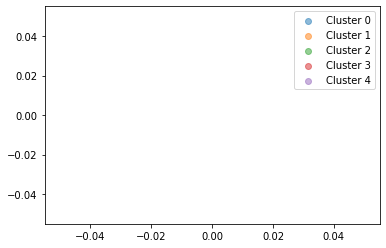

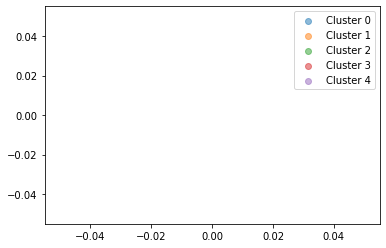

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

# Predict the cluster labels for each data point
predictions = model.transform(numericData).select('features', 'name_removedwords')

# Convert the predictions DataFrame to a Pandas DataFrame
pdf = predictions.toPandas()

# Extract the features and cluster labels from the Pandas DataFrame
X = pdf['features'].apply(lambda x: x.toArray()).tolist()
y = pdf['name_removedwords'].tolist()

# Convert the features and cluster labels to a new Pandas DataFrame
df = pd.DataFrame({'x': [x[0] for x in X], 'y': [x[1] for x in X], 'cluster': y})

# Create a scatter plot of the first 5 clusters
fig, ax = plt.subplots()
for i in range(5):
    data = df[df['cluster'] == i]
    ax.scatter(data['x'], data['y'], label=f'Cluster {i}', alpha=0.5)
ax.legend()
display(fig)



In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Convert string columns to numerical values

indexer = StringIndexer(inputCol="name", outputCol="name_numeric")
data_set = indexer.fit(data_set).transform(data_set)

In [ ]:
indexer = StringIndexer(inputCol="description", outputCol="description_numeric")
dataset = indexer.fit(data_set).transform(data_set)

In [ ]:
dataset.show()

+-------+--------------------+--------------------+------------+-------------------+
|book_id|                name|         description|name_numeric|description_numeric|
+-------+--------------------+--------------------+------------+-------------------+
|   4833|    The Glass Castle|A tender, moving ...|       104.0|               39.0|
|    590|Night (The Night ...|Born into a Jewis...|        73.0|               52.0|
|   4264|Angela's Ashes (F...|Imbued on every p...|        20.0|               67.0|
|   3361|    Eat, Pray, Love |A celebrated writ...|        36.0|               34.0|
|   4535|Into Thin Air: A ...|"A bank of clouds...|        53.0|               16.0|
|    518|Tuesdays with Morrie|Maybe it was a gr...|       117.0|               78.0|
|   3781|Running with Scis...|The true story of...|        90.0|               97.0|
|   3190|       Into the Wild|In April 1992 a y...|        54.0|               68.0|
|   3147|I Know Why the Ca...|"Sent by their mo...|        48.0| 

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql import SparkSession


In [ ]:
# Preprocess the data
assembler = VectorAssembler(inputCols=["name_numeric", "description_numeric"], outputCol="features")
df = assembler.transform(dataset)


In [ ]:
df=df.drop('name')

In [ ]:
df=df.drop('description')

In [ ]:
df.show()

+-------+------------+-------------------+------------+
|book_id|name_numeric|description_numeric|    features|
+-------+------------+-------------------+------------+
|   4833|       104.0|               39.0|[104.0,39.0]|
|    590|        73.0|               52.0| [73.0,52.0]|
|   4264|        20.0|               67.0| [20.0,67.0]|
|   3361|        36.0|               34.0| [36.0,34.0]|
|   4535|        53.0|               16.0| [53.0,16.0]|
|    518|       117.0|               78.0|[117.0,78.0]|
|   3781|        90.0|               97.0| [90.0,97.0]|
|   3190|        54.0|               68.0| [54.0,68.0]|
|   3147|        48.0|               24.0| [48.0,24.0]|
|    225|        12.0|               12.0| [12.0,12.0]|
|   3035|        29.0|               85.0| [29.0,85.0]|
|     99|        83.0|              119.0|[83.0,119.0]|
|   3594|       100.0|               30.0|[100.0,30.0]|
|   4971|       107.0|               44.0|[107.0,44.0]|
|   1381|        17.0|               57.0| [17.0

In [ ]:
from pyspark.ml.clustering import KMeans

# Split the data into training and testing sets
training_data = df.limit(137)
test_data = df.subtract(training_data)


In [ ]:
#define k-means model
# Train the KMeans model
kmeans = KMeans(k=10, seed=1)
model = kmeans.fit(training_data)

In [ ]:
# Predict the cluster for each data point in the testing set
predictions = model.transform(test_data)

In [ ]:
from pyspark.ml.feature import VectorAssembler


In [ ]:
# Get the terms found in the first three clusters
cluster_centers = model.clusterCenters()
for i in range(3):
    print("Cluster ", i+1, ":")
    print(cluster_centers[i])

Cluster  1 :
[ 55.23076923 100.38461538]
Cluster  2 :
[6.10714286 5.71428571]
Cluster  3 :
[103.5         34.21428571]


In [ ]:
# Pick the 136th book
if len(df.collect()) > 135:
    test_data = df.filter(f"book_Id == {135}").select("features")
    test_vector = training_data.rdd.map(lambda row: row[0]).first()
    predictions = model.predict(test_vector)
    print(f"The 136th book belongs to cluster {predictions}")
else:
    print("There are not enough books to make a prediction for the 136th book")

Py4JError: ignored